## Thomas Fermi Approximation for Spherical Trapping Potential

This notebook uses the Thomas Fermi approximation for the Gross-Pitaevskii equation for Bose-Einstein condensation at T=0 to simulate the particle density of a spherically symmetric shell potential in 3D. Created by Paul Shen, with help from Prof. Chris Herdman and former student Ellie Suit for Winter 2025 PHYS0500 Independent Study.

All values for physical parameters as well as the equation for the trapping potential were taken from Rhyno et al. (2021).

First, restart the kernel for easy variable refreshing.

In [ ]:
from IPython.display import display, Javascript

def restart_kernel():
    display(Javascript("Jupyter.notebook.kernel.restart()"))

restart_kernel()

<IPython.core.display.Javascript object>

We need numpy, scipy's quad (for integration), and matplotlib.

In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

## Define the variables

We base all other variables from 3 physical parameters, $\omega_0$, the frequency of the trapping potential, $m$, the mass of the BEC particles, and $a$, the scattering length of the interactions.

In [2]:
w0 = 80 * 2 * np.pi
m = 2
a = 5 * 10 ** -9

From $\omega_0$, $m$, and $a$ we can calculate the oscillator length $s_l = \sqrt{\hbar/2m\omega_0}$ and the interaction constant $U_0 = 4\pi\hbar^2a/m$. 

In [3]:
hbar = 1.05*10**-34
sl = np.sqrt(hbar/(2*m*w0))
U0 = 4*np.pi*hbar**2*a/m

To make all our integral dimensionless, calcuate the dimensionless $U_0$, $\tilde{U}_0 = U_0/(\hbar\omega_0 s_l) = 8\pi a/s_l$. This just ends up being 7/50. From now on, everything else will be expressed in dimensionless variables ($\tilde{r} = r/s_l$, $\tilde{V} = V/\hbar\omega_0$, $\tilde{\mu} = \mu/\hbar\omega_0$).

In [4]:
U0tilde = 8 * np.pi * a / sl
U0 = 7/50

Other parameters from Rhyno et. al that will be used later: $\Delta$ and $\Omega$ affect the trap potential, $r_{max}$ bounds our calculations range, $dim = 3$ since this is a 3D BEC, and $N_{target}$ is the number of particles and $dN$ is how close our recursive $\mu$ function needs to get to $N_{target}$.

In [5]:
delta = [50, 500, 1000]  # Trap parameters
omega = 250  # Trap parameter
r_max = 40# Edge of the computation box
dim = 3 # Number of dimensions in the BEC, for metric factor in integration

N_target = 50000
dN = 0.1

## Create functions for physical equations

This function defines the metric factor to be used in the integration of N.

In [6]:
def metric_factor(r, dim):
    if dim == 1:
        return 2
    elif dim == 2:
        return 2 * np.pi * r
    elif dim == 3:
        return 4 * np.pi * r**2
    else:
        return 0.0

This is our 3D dimensionless shell potential:
$$V(\tilde{r}, \Delta, \Omega) = 1/2 \sqrt{(\tilde{r}^2-\Delta)^2 + (2\Omega)^2}$$

In [7]:
# Potential function V(r)
def V(r, delta, omega):
    delta = np.atleast_1d(delta)  # Handle scalar or array input
    arg = (r**2 - delta[:, None])**2 + (2 * omega)**2
    return np.sqrt(arg) / 2 - omega if len(delta) > 1 else np.sqrt(arg[0]) / 2 - omega

We want to calculate the potential at the center, $V_0 = V(r=0)$, since if this potential is less than $\mu$, we will not have a true bubble BEC (there will be condensate at $r=0$, but if it is, we will see the condensate density go to 0 at the center of the trap.

In [8]:
# Compute the potential at the center of the trap (r=0)
V0 = V(0, delta, omega)

Since each potential has been scaled by $\Omega$, the minimum should technically be 0, but due to computational rounding errors, it will not be exactly 0. We want to make sure it is acceptably low.

In [9]:
# Function to compute the minimum value of V(r)
def V_min(delta, omega, r_max, num_points):
    delta = np.atleast_1d(delta)  # Handle scalar or array input
    r_values = np.linspace(0, r_max, num_points)  # Range of r values

    def compute_single(delta_val):
        V_values = [V(r, delta_val, omega) for r in r_values]
        return min(V_values)

    return np.array([compute_single(d) for d in delta]) if len(delta) > 1 else compute_single(delta[0])

# Compute the minimum value of V(r)
V_min_value = V_min(delta, omega, r_max, 1000)
print(V_min_value)

[[2.57198853e-05]
 [3.35985508e-04]
 [1.56866978e-04]]


This is the radial density integrand derived from the Thomas Fermi approximation, which will get integrated to find the total number of particles. It calculates $\mu-V(r)$, and if that is less than 0 ($V(r)>\mu$), returns 0 since the condensate density is 0 anywhere the trap potential exceeds the chemical potential. Therefore,
$$n(r) = \frac{\mu-V(r)}{U_0}, \quad V(r)<\mu$$
$$n(r)= 0, \quad V(r)>\mu$$

In [10]:
# Radial density integrand
def n_r(r, mu, delta, omega, U0, dim):
    delta = np.atleast_1d(delta)  # Handle scalar or array input
    V_r = V(r, delta, omega)
    result = np.maximum((mu - V_r) / U0, 0)
    return result if len(delta) > 1 else result[0]

We also define a function $\rho(r)$, which is the radial density $n(r)$ multiplied by the spherically symmetric metric factor ($4\pi r^2$ for 3D) to plug into our integral. Thus,
$$\rho(r) = 4\pi r^2\frac{\mu-V(r)}{U_0}, \quad V(r)<\mu$$
$$\rho(r)= 0, \quad V(r)>\mu$$

In [11]:
# Radial density integrand with metric factor
def rho_r(r, mu, delta, omega, U0, dim):
    delta = np.atleast_1d(delta)  # Handle scalar or array input
    metric = metric_factor(r, dim)
    V_r = V(r, delta, omega)
    result = np.maximum((mu - V_r) / U0, 0) * metric
    return result if len(delta) > 1 else result[0]

To make our integral easier, we calculate the Thomas Fermi radii of the condensate by finding where $V(r) = \mu$, and inverting to find the values for $r$. This will either return two $r$ values, $r_+$ and $r_-$, which occurs if we have a bubble condensate (and $V(0) > \mu$), or a single $r_{TF}$, if there is no bubble condensate (and $V(0) < \mu$). The equation for $r_{TF}$ is then:
$$r_{TF} = \sqrt{\Delta\pm\sqrt{4(\mu+\Omega)^2-(2\Omega)^2}}$$
The lower Thomas Fermi radii goes to 0 if $\Delta < \sqrt{4(\mu+\Omega)^2-(2\Omega)^2}$, or if $V(0) < \mu$.

In [12]:
# Integral for total number of particles N(mu)
def tf_radii(mu, delta, omega):
    
    # Treat delta as an array for uniform indexing
    delta = np.atleast_1d(delta)
    
    # Compute the 'term' inside the standard TF formula
    # term = 4 (mu + omega)^2 - (2 omega)^2
    term = 4.0 * (mu + omega)**2 - (2.0 * omega)**2
    
    # Safely take the square root by clipping negative values to 0
    # (In principle, if term < 0 by a small margin, r_min => 0 anyway.)
    term_clipped = np.clip(term, 0.0, None)
    root_term = np.sqrt(term_clipped)
    
    # r_minus^2 = delta - root_term
    # r_plus^2  = delta + root_term
    r_minus_sq = delta - root_term
    r_plus_sq  = delta + root_term
    
    # Likewise clip negative squares to 0 so that sqrt stays real
    r_minus_sq_clipped = np.clip(r_minus_sq, 0.0, None)
    r_plus_sq_clipped  = np.clip(r_plus_sq, 0.0, None)
    
    # Compute the physical radii
    r_TF_minus = np.sqrt(r_minus_sq_clipped)
    r_TF_plus  = np.sqrt(r_plus_sq_clipped)
    
    # If the input delta was a scalar, return scalars
    if delta.size == 1:
        return r_TF_minus[0], r_TF_plus[0]
    else:
        # Otherwise return arrays of the same shape
        return r_TF_minus, r_TF_plus

Now to find the total number of particles in the condensate, we can integrate the density $n(r)$ in spherical coordinates (or just $\rho(r)$ using scipy quad for integration), with the Thomas Fermi radii we just calculated as the bounds of integration. The total number of particles $N(\mu)$ is then
$$N(\mu) = \int n(r)\delta^3r = \int^{r_+}_{r_-} \rho(r)\delta r = \int^{r_+}_{r_-}4\pi r^2\frac{\mu-V(r)}{U_0}\delta r$$

In [13]:
def N_mu(mu, delta, omega, U0, dim):
    delta = np.atleast_1d(delta)  # Handle scalar or array input

    def integrate_single(delta_val):
        r_min, r_max = tf_radii(mu, delta_val, omega)
        if r_min is None or r_max is None:
            return 0.0  # No valid BEC region
        integral, _ = quad(rho_r, r_min, r_max, args=(mu, delta_val, omega, U0, dim))
        return integral

    return np.array([integrate_single(d) for d in delta]) if len(delta) > 1 else integrate_single(delta[0])

## Finding chemical potential from total particles

The functions above all assume that we start with the chemical potential $\mu$ and then find the density, Thomas Fermi radii, and total number of particles. However, we would ideally like to start with the total number of particles (since we have defined $N_{target} = 50000$). Thus, we define a function to calculate $\mu$ recursively, by first defining:
$$\mu_{crit} = V(r=0).$$
We define a $\mu_{min}$ and $\mu_{max}$ value as lower and upper bounds for the possible $\mu$ values associated with $N_{target}$. The initial $\mu_{min}$ is always 0, and $\mu_{max}$ starts at $\mu_{crit}$ and is doubled until $N(\mu_{max}) > N_{target}$.
The loop recursively bisects the interval $[\mu_{min},\mu_{max}]$, determines which half $\mu_{current}$ is in, the redefines $\mu_{min}$ and $\mu_{max}$ until $N(\mu_{current})$ is within $\delta N$ of $N_{target}$.

In [19]:
def find_mu_recursive(N_mu_func, V_func, delta, omega, U0, dim, N_target, dN):
    
    # 1) Define mu_crit = V(r=0)
    mu_crit = V_func(0.0, delta, omega)

    # 2) Define mu_min = 0 (since V_min is always 0)
    mu_min_val = 0.0

    # 3) Define mu_max = 2 * mu_crit
    mu_max_val = 2.0 * mu_crit

    # 4) Ensure N(mu_max) >= N_target by doubling mu_max until it is
    N_at_mu_max = N_mu_func(mu_max_val, delta, omega, U0, dim)
    while N_at_mu_max < N_target:
        mu_max_val *= 2.0
        N_at_mu_max = N_mu_func(mu_max_val, delta, omega, U0, dim)

    # 5) Start the bisection loop:
    #    - lower bound = mu_min_val (0)
    #    - upper bound = mu_max_val
    #    - initial guess mu = mu_crit
    mu_low = mu_min_val
    mu_high = mu_max_val
    mu = mu_crit

    # 6) While abs(N_mu(mu) - N_target) > dN, do:
    #    - If N(mu) > N_target => shift mu down
    #    - Else => shift mu up
    #    (We use bisection for stability.)
    N_current = N_mu_func(mu, delta, omega, U0, dim)
    while abs(N_current - N_target) > dN:
        if N_current > N_target:
            # Shift mu down
            mu_high = mu
        else:
            # Shift mu up
            mu_low = mu

        # Bisection update
        mu = 0.5 * (mu_low + mu_high)

        # Compute the number of particles at the new mu
        N_current = N_mu_func(mu, delta, omega, U0, dim)

    # Return the final mu that gives N(mu) ~ N_target
    return mu

Since we are concerned with the affects of multiple $\Delta$ values on the potential and $n(r)$, so we loop over all values in the delta array and recursively find the appropriate $\mu$ for each for $N_{target} = 50000$.

In [20]:
# Find the appropriate mu value through recursion and interpolation
# Find mu using the recursive function
mu_solutions = []
for d in delta:  # e.g. delta_array = np.linspace(...)
    mu_val = find_mu_recursive(N_mu, V, d, omega, U0, dim, N_target, dN)
    mu_solutions.append(mu_val)

# Print results for each delta and corresponding mu
print(f"Final mu values for N_target = {N_target}:")
print(mu_solutions)

Final mu values for N_target = 50000:
[array([1.98606168]), array([0.88691871]), array([0.70393154])]


Once we have a $\mu$ value associated with each $\Delta$ in delta, we can calculate the associated $r_{TF}(\mu, \Delta)$. Remember that the first $\Delta$ was used to calculate the first $\mu$, so each $\mu$ and $\Delta$ need to be paired index-wise when calculating $r_{TF}(\mu, \Delta)$. This helps us check the boundaries of each shell BEC and ensure that they are realistic values.

In [21]:
tf_radii_list = []

# Ensure delta and mu_solutions have the same length
for i in range(len(delta)):
    d = delta[i]                    # Trap parameter
    mu_array = mu_solutions[i]      # 1-element array
    mu_value = mu_array.item()      # Convert array to scalar
    # Now compute TF radii for this pair (mu_value, d)
    r_min, r_max = tf_radii(mu_value, d, omega)
    tf_radii_list.append((r_min, r_max))

print("TF radii for each (delta[i], mu_solutions[i]) pair:")
for i, (r_min, r_max) in enumerate(tf_radii_list):
    print(f"  i={i}: delta={delta[i]}, mu={mu_solutions[i].item():.3f}, r_min={r_min}, r_max={r_max}")

TF radii for each (delta[i], mu_solutions[i]) pair:
  i=0: delta=50, mu=1.986, r_min=0.0, r_max=10.637190922118023
  i=1: delta=500, mu=0.887, r_min=21.39732957371313, r_max=23.284206817366606
  i=2: delta=1000, mu=0.704, r_min=31.023412048965433, r_max=32.21099043556572


Visualize the shell potentials for $\Delta = 50, 500, 1000$. Also plots the different $\mu$ values.

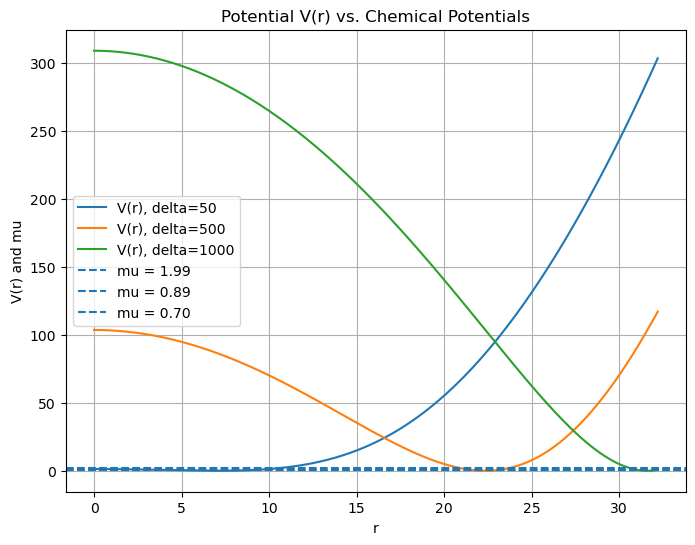

In [22]:
# Generate r-values
r_values = np.linspace(0, r_max, 500)

plt.figure(figsize=(8, 6))

# 1) Plot V(r) for each delta
for d in delta:
    V_values = [V(r, d, omega) for r in r_values]
    plt.plot(r_values, V_values, label=f"V(r), delta={d}")

# 2) Plot each mu from mu_solutions using .item() to get the scalar
for mu_arr in mu_solutions:
    mu = mu_arr.item()  # extract the float from the single-element array
    plt.axhline(y=mu, linestyle="--", label=f"mu = {mu:.2f}")

plt.xlabel("r")
plt.ylabel("V(r) and mu")
#plt.yscale('log') # Set the x-axis to log scale
plt.title("Potential V(r) vs. Chemical Potentials")
plt.legend()
plt.grid()
plt.show()

Finally, plot the radial density $n(r, \mu, \Delta)$ (not the integrand term $\rho(r, \mu, \Delta)$). The bounds of each curve should match the Thomas Fermi radii $r_{TF}$ we found earlier.

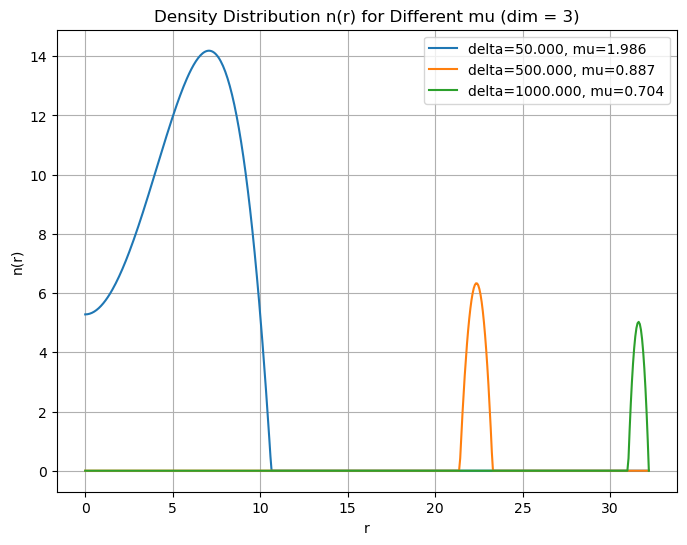

In [23]:
# Initialize plot
plt.figure(figsize=(8, 6))

# Loop over corresponding pairs of delta and mu_solutions
for d_val, mu_arr in zip(delta, mu_solutions):
    # Extract the float from the 1-element array mu_arr
    mu_val = mu_arr.item()  # or mu_arr[0]
    
    # Compute n(r) for each r in r_values
    # n_r(...) should return the radial density for (r, mu, delta, omega, U0, dim)
    n_values = [n_r(r, mu_val, d_val, omega, U0, dim) for r in r_values]
    
    # Plot with a legend label that shows both delta and mu
    plt.plot(r_values, n_values, label=f"delta={d_val:.3f}, mu={mu_val:.3f}")

# Plot settings
plt.xlabel("r")
plt.ylabel("n(r)")
plt.title(f"Density Distribution n(r) for Different mu (dim = {dim})")
plt.legend()
plt.grid(True)
plt.show()